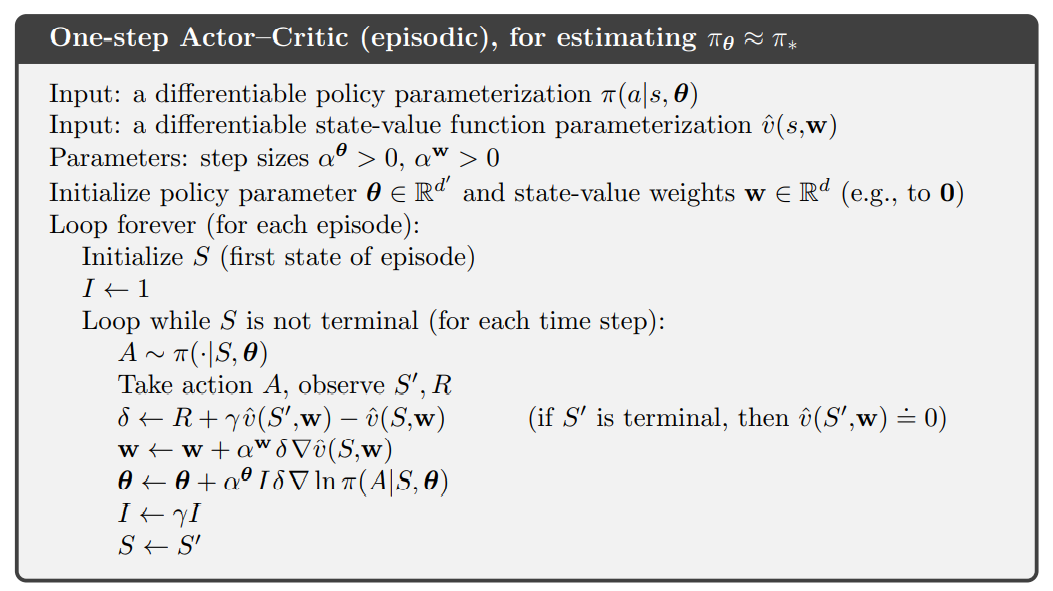

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
import copy

NUM_EPISODES = 4000
LEARNING_RATE = 0.029
learning_rate = 0.11
GAMMA = 0.99


In [2]:
import numpy as np
#rbf
from sklearn.kernel_approximation import RBFSampler

def gather_samples(env, n_episodes=10000):
    samples = []
    for _ in range(n_episodes):
        s = env.reset()
        done = False
        while not done:
            a = env.action_space.sample()
            samples.append(s)

            s, r, done, info = env.step(a)
    return samples

class v_hat_class:
    """
    this is our linear function approximator
    hark back to the example given above from sutton's own site for guidance
    
    """
    def __init__(self):
        # fit the featurizer to data
        self.env = env
        
        #get samples to train the rbf
        samples = gather_samples(env)
        self.featurizer = RBFSampler()
        self.featurizer.fit(samples)
        dims = self.featurizer.n_components

        # initialize linear model weights
        self.w = np.zeros(dims)

    def predict(self, s):
        x = self.featurizer.transform(s)
        return x @ self.w


    def grad(self, s):
        x = self.featurizer.transform(s)
        return x  
    
    def learn_rate_adjustment(self, big_t):
        expectation = []
        for state in self.samples:
            state_arr = np.array(state)
            base = state_arr.T.dot(np.array_state)
            expectation.append(base)
            
            
        return 1/(big_t *np.mean(expectation))
            


In [3]:
env = gym.make('CartPole-v0')
vhat = v_hat_class()

In [4]:
# noinspection PyMethodMayBeStatic
class Agent:
    def __init__(self, vhat):
        self.poly = PolynomialFeatures(1)
        self.w= np.random.rand(5, 2) * 0.01
        self.vhat = vhat
        

    def policy(self, state):
        z = state.dot(self.w)
        exp = np.exp(z)
        return exp/np.sum(exp)

    def __softmax_grad(self, softmax):
        s = softmax.reshape(-1,1)
        return np.diagflat(s) - np.dot(s, s.T)

    def grad(self, probs, action, state):
        dsoftmax = self.__softmax_grad(probs)[action,:]
        dlog = dsoftmax / probs[0,action]
        grad = state.T.dot(dlog[None,:])
        return grad
    
    def state_value(self, state):
        z = state.dot(self.w)
        

    def update_with(self, reward, probs, action, state, next_state, I, done):

                
        #vhat update         
        if done:
            next_state_discounted = 0
        else:
            next_state_discounted = (GAMMA * self.vhat.predict(next_state)) 
                       
        err = reward + next_state_discounted - self.vhat.predict(state)
        
        grad = self.vhat.grad(state)
        self.vhat.w += learning_rate * err * np.squeeze(grad)

        #policy  grad update
        grad = self.grad(probs, action, self.poly.fit_transform(state))
        self.w += LEARNING_RATE * I * err * grad

        #print("Grads update: " + str(np.sum(grads[i])))
            

In [5]:
def main(agent, train = 1, env = gym.make('CartPole-v0')):
    env = env
    np.random.seed(1)
    
    complete_scores = []

    for e in range(NUM_EPISODES):
        score = 0
        I = 1
        
        
        state = env.reset()[None, :]
        #state = agent.poly.fit_transform(state)

        while True:

            probs = agent.policy(agent.poly.fit_transform(state))
            action_space = env.action_space.n
            
            if train:
                action = np.random.choice(action_space, p=probs[0])
                

                next_state, reward, done,_ = env.step(action)
                next_state = next_state[None,:]
                #next_state = agent.poly.fit_transform(next_state.reshape(1, 4))  
                              
                agent.update_with(reward, probs, action, state, next_state, I, done)
                
                I *= GAMMA
                
                            
            else:
                action = np.argmax(probs[0])
                next_state, reward, done,_ = env.step(action)
                next_state = next_state[None,:]
                
            score += reward
            
            state = next_state

            if done:
                break
            
        complete_scores.append(score)
        
        if train:
            if np.mean(complete_scores[-20:]) >= 195:
                print("convergence has been attained")
                break
            
    env.close()
    plt.plot(np.arange(len(complete_scores)),
             complete_scores)
    
    return agent


convergence has been attained


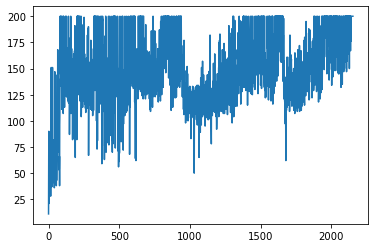

In [6]:
agent = Agent(vhat)

trained_agent = main(agent, 1, env)

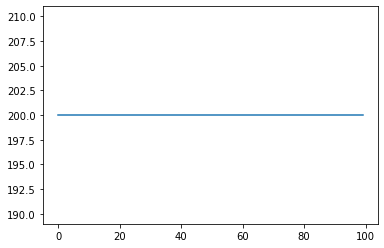

In [7]:
NUM_EPISODES = 100

trained_agent = main(trained_agent, 0, env)